In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats # linear regression
from sklearn.linear_model import LinearRegression 

In [3]:
LOB5 = pd.read_csv("INTC_2012-06-21_34200000_57600000_orderbook_5.csv",
header=None,usecols= list(range(20)),names=["AskPrice1","AskSize1","BidPrice1","BidSize1",
                       "AskPrice2","AskSize2","BidPrice2","BidSize2",
                       "AskPrice3","AskSize3","BidPrice3","BidSize3",
                       "AskPrice4","AskSize4","BidPrice4","BidSize4",
                       "AskPrice5","AskSize5","BidPrice5","BidSize5"])
LOB5.loc[:,["AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5",
"BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]] = LOB5.loc[:,["AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5",
"BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]]/10000
messages = pd.read_csv("INTC_2012-06-21_34200000_57600000_message_5.csv",
header=None, names=["Time","Type","OrderID","Size","Price","Direction"])
# add timestamp to the Limit Order BOOK
LOB5["Time"] = messages.Time
messages.loc[:,"Price"] = messages["Price"]/10000
messages["midprice"] = (LOB5.AskPrice1 + LOB5.BidPrice1)/2

execution = messages.loc[(messages.Type == 4) | (messages.Type == 5),:]
execution.loc[:,"Market Order Type"] = execution.loc[:,"Direction"].apply(lambda x: 'Market Order - Buy' if x==-1 else 'Market Order - Sell')
print(execution.shape)

(32483, 8)


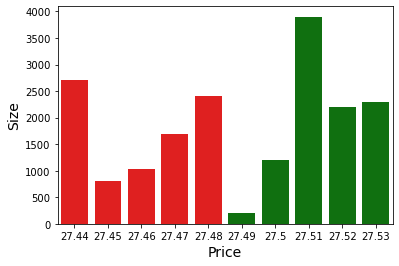

In [4]:
# lob.png
ax = sns.barplot(x= LOB5.loc[10000,["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5","AskPrice1","AskPrice2","AskPrice3","AskPrice4","AskPrice5"]].to_list(), 
y=LOB5.loc[10000,["BidSize1","BidSize2","BidSize3","BidSize4","BidSize5","AskSize1","AskSize2","AskSize3","AskSize4","AskSize5"]].to_list(), palette=["red"]*5+["green"]*5)
ax.set_xlabel('Price', fontsize = 14)
ax.set_ylabel('Size', fontsize = 14)
plt.show()

In [5]:
type(["red"]*5+["green"]*5)

list

In [6]:
LOB5.loc[10000,["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]].to_list()

[27.48, 27.47, 27.46, 27.45, 27.44]

**Type:**  
				1: Submission of a new limit order  
				2: Cancellation (Partial deletion   
				   of a limit order)  
				3: Deletion (Total deletion of a limit order)  
				4: Execution of a visible limit order  
				5: Execution of a hidden limit order  
				7: Trading halt indicator 	  			   
				   (Detailed information below)
				   
**Direction:** 
				-1: Sell limit order
				1: Buy limit order
				
				Note: 
				Execution of a sell (buy) limit
				order corresponds to a buyer (seller) 
				initiated trade, i.e. Buy (Sell) trade.
That is the execution of a <span style='color:blue'>sell limit order</span> correponds to the arrival of <span style='color:red'>a buy market order</span>.

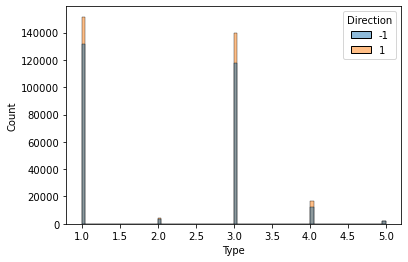

In [7]:

sns.histplot(data=messages, x = "Type", hue="Direction",palette=sns.color_palette("tab10",2))
None

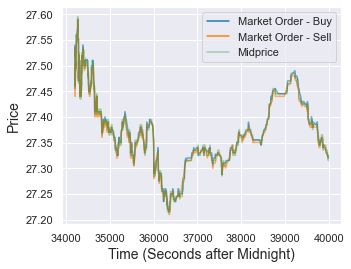

In [8]:
# midprice.png
sns.set(rc={'figure.figsize':(5,4)})
ax = sns.lineplot(data = execution.loc[execution.Time<=40000], x = "Time", y = "Price",ci=None,hue="Market Order Type",palette=sns.color_palette("tab10",2),alpha = 0.6) 
ax = sns.lineplot(data = messages.loc[messages.Time<=40000],x = "Time",y ="midprice",label="Midprice",ci=None,alpha = 0.3, color ="green")
ax.set_xlabel('Time (Seconds after Midnight)', fontsize=14)
ax.set_ylabel('Price', fontsize=14)
# The excution of the Limit order orginates from the arrival of Market Order.
plt.legend() 
None

In [9]:
interval_point = np.arange(execution.Time[0],execution.Time[581029]+300,step=300)
execution["interval"] = pd.cut(execution.loc[:,"Time"], bins= interval_point, right=True, labels=np.arange(5,5*78+1,step=5), retbins=False, precision=8, include_lowest=True, duplicates='raise', ordered=True)

# Estimate permanent impact $b$ for every 5 minutes

In [10]:

MO_volume = execution.loc[:,["Market Order Type","interval","Size"]].groupby(["interval","Market Order Type"]).sum().reset_index(level="Market Order Type").pivot(columns="Market Order Type",values="Size")
last_midprice = execution.loc[:,["Time","midprice","interval"]].groupby("interval").tail(1).set_index("interval")
binned_data = last_midprice.join(MO_volume)

In [11]:
if "midprice_last" not in binned_data.columns:
    binned_data = binned_data.join(last_midprice.loc[:,"midprice"].shift(1),rsuffix="_last")
binned_data.dropna(inplace=True)

In [12]:
binned_data["price_change"] = binned_data.midprice - binned_data.midprice_last
binned_data["net order flow"] = binned_data["Market Order - Buy"]+ - binned_data["Market Order - Sell"]
x = binned_data["net order flow"]
y = binned_data["price_change"]
x_truncated = x[(x <= x.quantile(0.995))&(x >= x.quantile(0.005))]
y_truncated = y[(x <= x.quantile(0.995))&(x >= x.quantile(0.005))]
slope, intercept, r_value, p_value, std_err = stats.linregress(x_truncated, y_truncated)
print(f"b = {slope}")


b = 6.934504671235714e-07


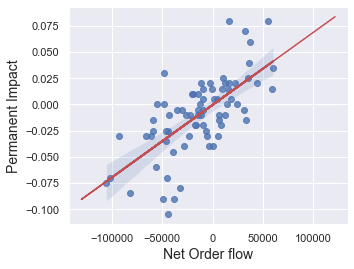

In [13]:
# regression_b.png
sns.set(rc={'figure.figsize':(5,4)})
ax = sns.regplot(x=x_truncated,y=y_truncated,ci=95)
ax.plot(x, intercept + slope*x, 'r', label='fitted line')
ax.set_xlabel('Net Order flow', fontsize=14)
ax.set_ylabel('Permanent Impact', fontsize=14)
plt.show()

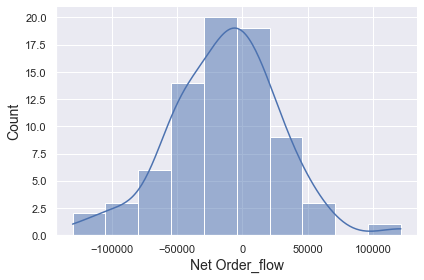

In [14]:
# net_flow.png
ax= sns.displot(data=binned_data,x="net order flow",bins=10,kde=True,height=4,aspect=6/4)
ax.set_xlabels('Net Order_flow', fontsize = 14)
ax.set_ylabels('Count', fontsize = 14)
plt.show()

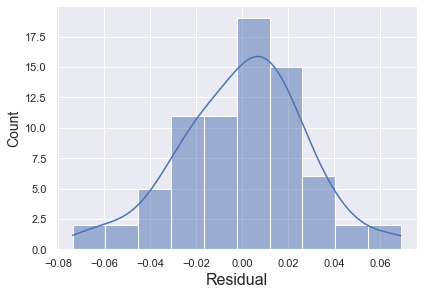

In [15]:
# residual.png
resid = y_truncated - (intercept + slope*x)
ax = sns.displot(x=resid,bins=10,kde =True,height=4,aspect=6/4)
ax.set_xlabels("Residual",fontsize =16)
ax.set_ylabels("Count",fontsize = 14)
plt.show()

In [16]:
LOB5["rounded_time"] = LOB5.Time.apply(np.ceil)
LOB5_subset = LOB5.groupby("rounded_time").tail(1)

In [17]:
LOB5_subset.head(5)

AskPrice1  AskSize1  BidPrice1  BidSize1  AskPrice2  AskSize2  \
188       27.53       326      27.52       262      27.54       673   
287       27.53       600      27.52       422      27.54       504   
637       27.47       200      27.44       285      27.48       600   
1022      27.48       200      27.45       400      27.49       100   
1060      27.48       300      27.46      1000      27.49       200   

      BidPrice2  BidSize2  AskPrice3  AskSize3  ...  AskPrice4  AskSize4  \
188       27.51      3215      27.55       400  ...      27.56       200   
287       27.51      2847      27.55       400  ...      27.56       200   
637       27.42       663      27.49       600  ...      27.50       600   
1022      27.44       800      27.50       100  ...      27.51       100   
1060      27.45      4200      27.50       100  ...      27.51       100   

      BidPrice4  BidSize4  AskPrice5  AskSize5  BidPrice5  BidSize5  \
188       27.49       400      27.57      1100      27.48      3761   
287       27.49       400      27.57      1100      27.48      3761   
637       27.39       400      27.51       600      27.38      1100   
1022      27.42       663      27.52       600      27.40     66108   
1060      27.43       100      27.52       600      27.42       763   

              Time  rounded_time  
188   34200.989774       34201.0  
287   34201.671891       34202.0  
637   34202.978945       34203.0  
1022  34203.986662       34204.0  
1060  34204.994291       34205.0  

[5 rows x 22 columns]

**In the third row of the table we show the parameter estimate for temporary impact. To
estimate this parameter, which we denote by k, we assume that temporary price impact is
linear in the rate of trading so the difference between the execution price that the investor
receives and the midprice is $k\Delta Q$, where Q is the volume of trades. In the continuous time
setting $\Delta Q = ν\Delta t$, when the agent trades at a speed of ν over a small time interval $\Delta t$. To
estimate the impact parameter k, we take a snapshot of the buy side of the LOB each second,
determine the price per share for various volumes (by walking through the LOB), compute
the difference between the price per share and the best quote at that time, and perform a linear
regression. The slope of the linear regression is an estimate of the temporary price impact per
share at that time. We do this for every second of every trading day and in the table we report
the mean and standard deviation of these daily estimates when we exclude the first and last
half-hour of the trading day, and remove the upper and lower 0.5% tails**

For a snapshot on the order-book which is taken every second as done by the article, the snapshot the upper and lower 0.5% limit order. As only level-5 data (5 price levels away from the midprice) is available, and this report focuses on the understanding the method used by the authors, level-5 data can serve the purpose to illustrate how the parameter *k* is estimated for every minute in real-world trading. 

In [18]:
# Based on Numpy
def walk_LOB(BidPrice, BidSize,Time):
    '''Walk through the buy(Bid) side, and assume the volume increase from 0 to the sum of level 5 volume N_t.  

    return a pandas dataframe of size as large as the "total volume"/50 (Buy as multiple times of 50, e.g 50,100,150...)   
    -- 'Price Impact', 'Liquidation Volume', 'Time' 
    
    Input: BidPrice (list) For LOB with 5 levels away from the midprice, it should be of length 5
           BidSize (list) The corresponding size the the 5 level.'''
    BidPrice = BidPrice.copy().values
    BidSize = BidSize.copy().values
    Price_diff = BidPrice[0] - BidPrice[1:5]   # Of length 4, best quote - worse bid, corresponding the 4 level next to the best quote
    total_volume = sum(BidSize)
    accumulated_volume = np.cumsum(BidSize) # accumulated sum
    df = []  # Initiate an empty list
    for i in range(1,int(total_volume//50*50) + 2,50):
           payment_diff = np.minimum(np.maximum(0, i - accumulated_volume[:4]),BidSize[1:5]) @ Price_diff
           shares = i
           price_impact = payment_diff/shares
           df.append([Time,shares,price_impact])
    return df
                  
# Testing
bp = LOB5.loc[10000,["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]]
bs = LOB5.loc[10000,["BidSize1","BidSize2","BidSize3","BidSize4","BidSize5"]]
t = LOB5.loc[10000,"Time"]
LOB5.loc[1][["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]]
#walk_LOB(bp,bs,t)
# Test on a slice of df
""" test_sample = LOB5.loc[1:10,:]
result = test_sample.apply(lambda x: walk_LOB(x[["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]], x[["BidSize1","BidSize2","BidSize3","BidSize4","BidSize5"]],x["Time"]),axis=1,result_type=None).explode(ignore_index=True).to_list()
pd.DataFrame(result,columns=["Time","Volume","Price Impact"]) """

' test_sample = LOB5.loc[1:10,:]\nresult = test_sample.apply(lambda x: walk_LOB(x[["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]], x[["BidSize1","BidSize2","BidSize3","BidSize4","BidSize5"]],x["Time"]),axis=1,result_type=None).explode(ignore_index=True).to_list()\npd.DataFrame(result,columns=["Time","Volume","Price Impact"]) '

In [19]:
walk_result = LOB5_subset.apply(lambda x: walk_LOB(x[["BidPrice1","BidPrice2","BidPrice3","BidPrice4","BidPrice5"]], x[["BidSize1","BidSize2","BidSize3","BidSize4","BidSize5"]],x["Time"]),axis=1,result_type=None).explode(ignore_index=True).to_list()


""" import swifter   # ENhance the speed by parallel computing

def some_function(data):
    return data * 10

data['out'] = data['in'].swifter.apply(some_function) """

" import swifter   # ENhance the speed by parallel computing\n\ndef some_function(data):\n    return data * 10\n\ndata['out'] = data['in'].swifter.apply(some_function) "

# Estimate temporary $k$ for every minute

In [20]:
walk_result = pd.DataFrame(walk_result,columns=["Time","Volume","Price Impact"])
walk_result.loc[:,"Time"] = walk_result.loc[:,"Time"].apply(np.ceil)

In [21]:
draw_data = walk_result.loc[(walk_result.Time<=39660)&(walk_result.Time>39600)]
# Regression
X = draw_data["Volume"].to_numpy().reshape(-1,1)
y = draw_data["Price Impact"].to_numpy().reshape(-1,1)
model = LinearRegression(fit_intercept=False)
model.fit(X,y)
slope_k = model.coef_[0][0]

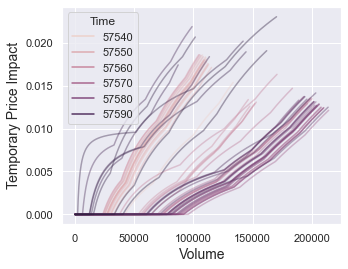

In [22]:
draw_data_end = walk_result.loc[(walk_result.Time>=57540)&(walk_result.Time<57600)]
ax = sns.lineplot(data = draw_data_end,x="Volume",y="Price Impact",hue = "Time",alpha = 0.4)
ax.set_ylabel('Temporary Price Impact', fontsize = 14)
ax.set_xlabel('Volume', fontsize = 14)
plt.show()

In [23]:
interval_point = np.arange(walk_result.Time[0]-1,walk_result.Time[37606893]+60,step=60)
walk_result["minute_interval"] =  pd.cut(walk_result.loc[:,"Time"], bins= interval_point, right=True, labels= np.arange(1,391) , retbins=False, precision=8, include_lowest=False, duplicates='raise', ordered=True)

In [24]:
walk_result

Time  Volume  Price Impact minute_interval
0         34201.0       1      0.000000               1
1         34201.0      51      0.000000               1
2         34201.0     101      0.000000               1
3         34201.0     151      0.000000               1
4         34201.0     201      0.000000               1
...           ...     ...           ...             ...
37606889  57600.0  184501      0.025865             390
37606890  57600.0  184551      0.025869             390
37606891  57600.0  184601      0.025873             390
37606892  57600.0  184651      0.025877             390
37606893  57600.0  184701      0.025881             390

[37606894 rows x 4 columns]

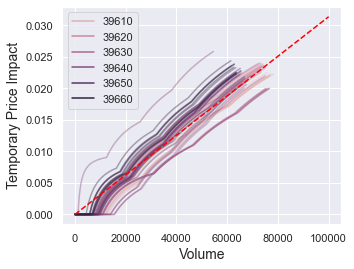

In [25]:
ax = sns.lineplot(data = draw_data,x="Volume",y="Price Impact",hue = "Time",alpha = 0.4)
ax = sns.lineplot(x = np.linspace(0,1e+5,500),y = slope_k*np.linspace(0,1e+5,500),linestyle = "dashed",color="red")
ax.set_ylabel('Temporary Price Impact', fontsize = 14)
ax.set_xlabel('Volume', fontsize = 14)
plt.show()

In [26]:
# apply linear regresion using numpy
def linReg(x, y):
    '''linear regression using numpy starting from two one dimensional numpy arrays'''
    A = np.vstack([x]).T
    slope = np.linalg.lstsq(A, y, rcond=None)[0][0]
    return pd.Series({'slope':slope})
daily_k = walk_result.groupby('minute_interval').apply(lambda x: linReg(x["Volume"], x["Price Impact"]))

In [27]:
daily_k.reset_index(inplace = True)

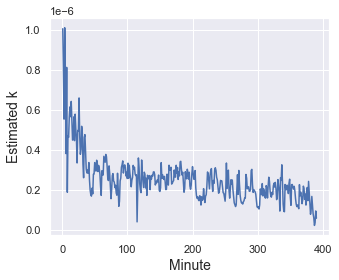

In [28]:
# k_oneday.png
ax = sns.lineplot(data = daily_k, x = "minute_interval",y="slope")
ax.set_ylabel('Estimated k', fontsize=14)
ax.set_xlabel('Minute', fontsize=14)
#plt.hlines(y=daily_k["slope"].mean(),xmin=0,xmax=390,colors="red",linestyles="dotted")
plt.show()

# Estimate $\lambda +$ (hourly mean arrival)  $\lambda -$ $E(\eta +)$ $E(\eta -)$

In [29]:
interval_point = np.arange(np.floor(execution.Time[0]),execution.Time[581029]+1801,step=3600)
execution["hour"] = pd.cut(execution.loc[:,"Time"], bins= interval_point, right=True, labels=np.arange(1,8), retbins=False, precision=8, include_lowest=True, duplicates='raise', ordered=True)

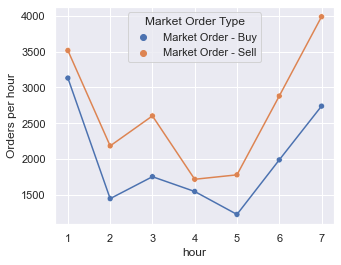

In [50]:
df = execution[["Market Order Type","hour"]].groupby(["hour","Market Order Type"]).size().reset_index().rename({0:"Orders per hour"},axis=1)
sns.lineplot(data=df, x="hour",y="Orders per hour",hue="Market Order Type",legend=None)
sns.scatterplot(data=df, x="hour",y="Orders per hour",hue="Market Order Type")
None

In [51]:
execution

Time  Type    OrderID  Size  Price  Direction  midprice  \
0       34200.005743     4   15835012    34  27.52         -1    27.515   
10      34200.211338     4   15835012    66  27.52         -1    27.515   
11      34200.211338     4   16114545   100  27.52         -1    27.520   
12      34200.211338     5          0   125  27.52         -1    27.520   
50      34200.233926     4   16168872   100  27.52         -1    27.520   
...              ...   ...        ...   ...    ...        ...       ...   
580903  57599.070817     4  287059301   100  26.71          1    26.715   
580929  57599.214945     4  287059301  3700  26.71          1    26.715   
580952  57599.302349     4  287059301   500  26.71          1    26.715   
580959  57599.408331     4  287059301  3800  26.71          1    26.715   
581029  57599.948442     4  287059301  3800  26.71          1    26.715   

          Market Order Type interval hour  
0        Market Order - Buy        5    1  
10       Market Order - Buy        5    1  
11       Market Order - Buy        5    1  
12       Market Order - Buy        5    1  
50       Market Order - Buy        5    1  
...                     ...      ...  ...  
580903  Market Order - Sell      390    7  
580929  Market Order - Sell      390    7  
580952  Market Order - Sell      390    7  
580959  Market Order - Sell      390    7  
581029  Market Order - Sell      390    7  

[32483 rows x 10 columns]

In [48]:
df

hour    Market Order Type  Orders per hour
0     1   Market Order - Buy             3132
1     1  Market Order - Sell             3518
2     2   Market Order - Buy             1444
3     2  Market Order - Sell             2182
4     3   Market Order - Buy             1751
5     3  Market Order - Sell             2602
6     4   Market Order - Buy             1544
7     4  Market Order - Sell             1715
8     5   Market Order - Buy             1223
9     5  Market Order - Sell             1777
10    6   Market Order - Buy             1986
11    6  Market Order - Sell             2880
12    7   Market Order - Buy             2739
13    7  Market Order - Sell             3990

In [49]:
execution[["Size","Market Order Type"]].groupby(["Market Order Type"]).mean()

Size
Market Order Type              
Market Order - Buy   342.987843
Market Order - Sell  307.109730